<a href="https://colab.research.google.com/github/Guljeren/Ml_lab/blob/main/lab_4_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset URL: https://www.kaggle.com/datasets/uciml/german-credit
Базовая        : 0.5500
С дисбалансом  : 0.5250
Копирование    : 0.5500
SMOTE          : 0.4750
ADASYN         : 0.5350
TomekLinks     : 0.5500


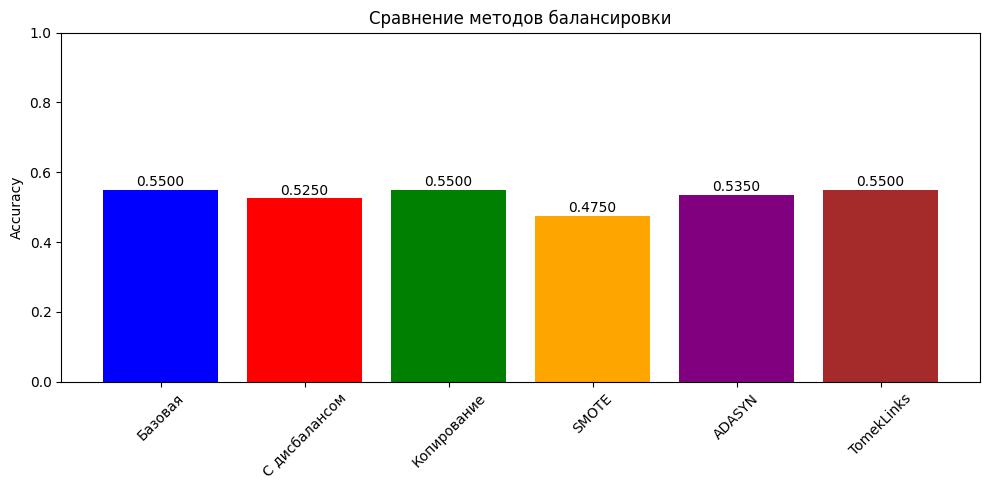

In [2]:
import os, json, pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import TomekLinks

# Загрузка данных
kaggle_config = {"username": "your", "key": "your"}
os.makedirs('/root/.config/kaggle', exist_ok=True)
with open('/root/.config/kaggle/kaggle.json', 'w') as f: json.dump(kaggle_config, f)
os.chmod('/root/.config/kaggle/kaggle.json', 0o600)

from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi(); api.authenticate()
api.dataset_download_files('uciml/german-credit', path='./data', unzip=True)
csv_path = './data/' + [f for f in os.listdir('./data') if f.endswith('.csv')][0]
df = pd.read_csv(csv_path)

# Преобразование в классификацию
def amount_to_class(x):
    if x <= 1500: return 0
    elif x <= 5000: return 1
    else: return 2

df['target'] = df['Credit amount'].apply(amount_to_class)
X = df.drop(['Credit amount', 'target'], axis=1)
y = df['target']

# Кодирование категориальных
for col in X.select_dtypes(include=['object']).columns:
    X[col] = pd.factorize(X[col])[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. Базовая модель
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
acc_base = accuracy_score(y_test, dt.predict(X_test))
results = {'Базовая': acc_base}

# 2. Создание дисбаланса (оставляем 10% от мажоритарного)
class_counts = y_train.value_counts()
maj_class, maj_count = class_counts.idxmax(), class_counts.max()
min_class = class_counts.idxmin()
min_indices = y_train[y_train == min_class].index
n_keep = int(maj_count * 0.1)

np.random.seed(42)
keep_idx = np.random.choice(min_indices, n_keep, replace=False)
all_idx = list(y_train[y_train != min_class].index) + list(keep_idx)

X_imb = X_train.loc[all_idx]
y_imb = y_train.loc[all_idx]

dt_imb = DecisionTreeClassifier(random_state=42)
dt_imb.fit(X_imb, y_imb)
acc_imb = accuracy_score(y_test, dt_imb.predict(X_test))
results['С дисбалансом'] = acc_imb

# 3. Методы балансировки
methods = {
    'Копирование': RandomOverSampler(random_state=42),
    'SMOTE': SMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'TomekLinks': TomekLinks()
}

for name, sampler in methods.items():
    try:
        X_bal, y_bal = sampler.fit_resample(X_imb, y_imb)
        dt_bal = DecisionTreeClassifier(random_state=42)
        dt_bal.fit(X_bal, y_bal)
        acc_bal = accuracy_score(y_test, dt_bal.predict(X_test))
        results[name] = acc_bal
    except: results[name] = None

# Выводы
for method, acc in results.items():
    if acc: print(f"{method:15}: {acc:.4f}")

# Визуализация
valid = {k: v for k, v in results.items() if v}
plt.figure(figsize=(10,5))
bars = plt.bar(range(len(valid)), list(valid.values()), color=['blue','red','green','orange','purple','brown'])
plt.xticks(range(len(valid)), list(valid.keys()), rotation=45)
plt.ylabel('Accuracy'); plt.title('Сравнение методов балансировки'); plt.ylim(0, 1)
for bar, acc in zip(bars, valid.values()):
    plt.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.01, f'{acc:.4f}', ha='center')
plt.tight_layout(); plt.show()
